In [1]:
import pandas as pd
import numpy as np
import itertools as itt
import seaborn as sns
import matplotlib.pyplot as plt

import os

from MARM.paths import get_results_path, get_figure_dir
from MARM.estimation import get_model, get_edata
from MARM.visualize import plot_and_save_fig

dataset = 'EGF_EGFR_MEKi_PRAFi_RAFi'
variant = 'pRAF'
model_name = 'RTKERK'

figdir = get_figure_dir(model_name, variant, dataset)

In [2]:
df_sizes = pd.DataFrame(columns=['states', 'parameters', 'experiments'])

for r in range(5):
    for combo in itt.combinations(dataset.replace('_EGFR','').split('_'), r=r):
        instance = '_'.join(combo)
        model = get_model(model_name, variant, instance)
        edata = get_edata(dataset, instance, model)
        edata = [
            e
            for e in edata
            if e[3] is not None and
            (e[3].fixedParameters[model.getFixedParameterNames().index('EGFR_crispr')] != 1.0) is ('EGFR' in combo)
        ]
        df_sizes = df_sizes.append(pd.Series({
            'experiments': len(edata),
            'states': model.nx_rdata,
            'parameters': model.np() - sum(par.endswith('phi') for par in model.getParameterNames()),
        }, name=instance.replace('_',',')))
df_sizes = df_sizes.sort_values(by='states')

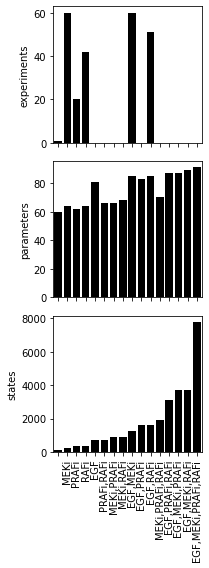

In [3]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3, 8), sharex=True)
sns.barplot(x=df_sizes.index,y=df_sizes.experiments,ax=ax1, color='k')
sns.barplot(x=df_sizes.index,y=df_sizes.parameters,ax=ax2, color='k')
sns.barplot(x=df_sizes.index,y=df_sizes.states,ax=ax3, color='k')
plt.xticks(rotation=90)
plot_and_save_fig(figdir, 'multimodel_sizes.pdf')

In [5]:
df_sizes.experiments.sum()

234

In [8]:
df_sizes

,states,parameters,experiments
,113,60,1
MEKi,258,64,60
PRAFi,348,62,20
RAFi,348,64,42
EGF,711,81,0
"PRAFi,RAFi",727,66,0
"MEKi,PRAFi",889,66,0
"MEKi,RAFi",889,68,0
"EGF,MEKi",1252,85,60
"EGF,PRAFi",1612,83,0


In [9]:
benchmark_data_file = os.path.join(get_results_path(model_name, variant),
                                   'EGF_EGFR_MEKi_PRAFi_RAFi_multimodel_benchmark.csv')
df_bm = pd.read_csv(benchmark_data_file)
df_bm = df_bm.replace([np.inf, -np.inf], np.nan).dropna(subset=['fval_single','fval_multi'],axis=0)
df_bm.t_single /= 3600
df_bm.t_multi /= 3600

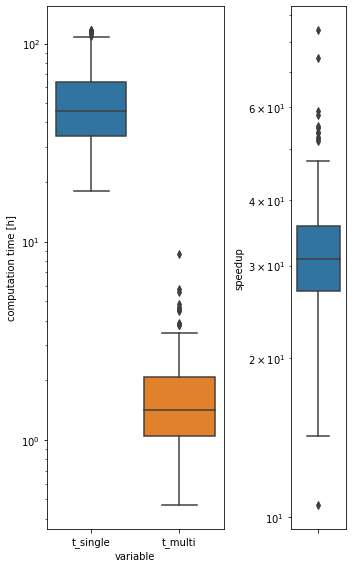

In [10]:
times = df_bm.melt(value_vars=['t_single','t_multi'])

fig = plt.figure(figsize=(5, 8))
grid = plt.GridSpec(1, 3)
ax1 = fig.add_subplot(grid[0,0:2])
ax2 = fig.add_subplot(grid[0,2])
sns.boxplot(
    x='variable', y='value',
    data=times,
    ax=ax1
)
ax1.set_yscale('log')
ax1.set_ylabel('computation time [h]')

sns.boxplot(
    y=df_bm.t_ratio,
    ax=ax2
)
ax2.set_yscale('log')
ax2.set_ylabel('speedup')

plot_and_save_fig(figdir, 'multimodel_benchmark.pdf')

In [11]:
df_bm.max()

Unnamed: 0.1    0.000000e+00
Unnamed: 0      9.830000e+02
t_single        1.167972e+02
t_multi         8.698617e+00
fval_single     6.516559e+07
fval_multi      6.517511e+07
t_ratio         8.408946e+01
dtype: float64

In [12]:
df_bm.min()

Unnamed: 0.1        0.000000
Unnamed: 0         10.000000
t_single           18.061776
t_multi             0.468108
fval_single     15158.308248
fval_multi      15160.259740
t_ratio            10.527651
dtype: float64

In [13]:
df_bm.median()

Unnamed: 0.1         0.000000
Unnamed: 0         524.000000
t_single            45.614902
t_multi              1.407026
fval_single     249486.512174
fval_multi      249486.299914
t_ratio             30.941923
dtype: float64